# Create data sets for Keras-genomics

In [1]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'stringr',
    'caret',
    'caTools',
    'RPostgreSQL',
    'RUnit',
    'igraph',
    'tibble'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

# source("http://bioconductor.org/biocLite.R")
# biocLite("BSgenome.Hsapiens.UCSC.hg38")
library(BSgenome.Hsapiens.UCSC.hg38)
hg38 = BSgenome.Hsapiens.UCSC.hg38

(.packages())

source("utility_functions.R")
source("stat_functions.R")
source("plot_functions.R")
source("~/git-repos/BDDS/trenadb/src/utils.R")

# rm(list = setdiff(ls(), lsf.str()))

Loaded glmnet 2.0-5


Attaching package: ‘dplyr’

The following object is masked from ‘package:xgboost’:

    slice

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:Matrix’:

    expand

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following object is masked from ‘package:glmnet’:

    auc

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘igraph’

The following object is masked from ‘package:stringr’:

    %>%

The following objects are masked from ‘package:tidyr’:

    %>%, crossing

The following objects are masked from ‘package:dplyr’:

    %>%, as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

[1] "BSgenome.Hsapiens.UCSC.hg38" "BSgenome"                   
 [3] "rtracklayer"                 "Biostrings"                 
 [5] "XVector"                     "GenomicRanges"              
 [7] "GenomeInfoDb"                "IRanges"                    
 [9] "S4Vectors"                   "stats4"                     
[11] "BiocGenerics"                "parallel"                   
[13] "tibble"                      "igraph"                     
[15] "RUnit"                       "RPostgreSQL"                
[17] "DBI"                         "caTools"                    
[19] "caret"                       "lattice"                    
[21] "stringr"                     "pROC"                       
[23] "tidyr"                       "dplyr"                      
[25] "glmnet"                      "foreach"                    
[27] "Matrix"                      "xgboost"                    
[29] "ggplot2"                     "RColorBrewer"               
[31] "stats"                       "graphics"                   
[33] "grDevices"                   "utils"                      
[35] "datasets"                    "methods"                    
[37] "base"

[1] --- test.locStringToBedTable
[1] --- test.getFimoHits
[1] --- test.getHits
[1] --- test.createHintTable
[1] found 194 hint hits in 101 bases
[1] found 16 hint hits in 101 bases
[1] found 14 hint hits in 101 bases
[1] found 10 hint hits in 19 bases
[1] found 995 hint hits in 20019 bases
[1] --- test.createHintTable_ignoreStrand
[1] found 44 hint hits in 12 bases
[1] found 44 hint hits in 12 bases
[1] eliminating 11 double-stranded hits
[1] --- test.createWellingtonTable
[1] found 126 wellington hits in 19 bases
[1] found 378 wellington hits in 20019 bases
[1] found 68 wellington hits in 12 bases
[1] found 4 wellington hits in 12 bases
[1] found 126 wellington hits in 19 bases
[1] found 64 wellington hits in 19 bases
[1] found 24 wellington hits in 19 bases
[1] --- test.createWellingtonTable_ignoreStrand, deferred
[1] found 26 wellington hits in 10 bases
[1] found 26 wellington hits in 10 bases
[1] eliminating 13 double-stranded hits
[1] --- test.createPiqTable
[1] found 342 piq hits

## Load Data (with overlaps)

In [2]:
load("train_test_valid_data_sets.Rdata")

## tasks:
- within each df:
 - select all cs hits
 - find subset of cs hits not within 100 bp of each other
 - remove all non cs hits within 100 bp of that set
 - of the remaining non cs hits, remove any within 100 bp of eachother

## Function for filtering within a set

In [3]:
# NOTE: this function assumes the locations are on the same chromasome

# sort centers and keep track of distance to last good center
get.ind.locs.greedy.fast <- function(df.with.centers.and.ids, thresh=100) {
    df.tbl <- as_data_frame(df.with.centers.and.ids)
    df.ordered <- df.tbl[with(df.tbl, order(center)), ]
    
    centers <- df.ordered$center
    locids <- df.ordered$locid
    ind.ids <- c()
    
    for (r in 1:nrow(df.ordered)) {
        if (length(ind.ids) == 0) {
            ind.ids <- c(ind.ids, locids[r])
            last.ind.cent <- centers[r]
        } else {
            this.cent <- centers[r]
            if (this.cent - last.ind.cent > thresh) {
                ind.ids <- c(ind.ids, locids[r])
                last.ind.cent <- this.cent
            }
        }
    }
    return(subset(df.ordered, locid %in% ind.ids))
}

In [4]:
# remove overlaps in df, such that:
#  - preservation of cs hits is prioritized
#  - there are no overlaps (within 100bp) of any location

subset.overlaps.cshit.aware <- function(df, balanced=FALSE) {
    
    # add a key to the original df
    df$locid <- 1:nrow(df)
    df$center <- as.integer(round(0.5*(df$start + df$end)))

    # subset out only rows with a cs hit
    cshits.df <- df[df$csscore>0,]

    # get a greedy set of independent locations
    cshits.ind.locs.df <- get.ind.locs.greedy.fast(cshits.df)

    ### double-check no overlaps in ind cs set
    hits.gr <- GRanges(seqnames="chr19",
                     IRanges(start=cshits.ind.locs.df$center-50, end=cshits.ind.locs.df$center+50))
    hits.hits.overlaps.df <- as_data_frame(findOverlaps(hits.gr))
    hits.hits.noself.df <- subset(hits.hits.overlaps.df, subjectHits != queryHits)
    stopifnot(nrow(hits.hits.noself.df)==0)

    ### remove non cs hits that overlap cs hits
    cs.misses.df <- df[df$csscore==0,]
    misses.gr <- GRanges(seqnames="chr19",
                     IRanges(start=cs.misses.df$center-50, end=cs.misses.df$center+50))
    hits.misses.overlaps.df <- as_data_frame(findOverlaps(misses.gr, hits.gr))
    misses.to.remove <- unique(hits.misses.overlaps.df$queryHits)
    misses.no.overlap.with.hits.df <- cs.misses.df[-c(misses.to.remove),]

    ### double check no overlap of pruned hits with ind cs set
    hits.no.misses.gr <- GRanges(seqnames="chr19",
                     IRanges(start=misses.no.overlap.with.hits.df$center-50,
                             end=misses.no.overlap.with.hits.df$center+50))
    hits.no.misses.misses.overlaps.df <- as_data_frame(findOverlaps(hits.gr, hits.no.misses.gr))
    stopifnot(nrow(hits.no.misses.misses.overlaps.df)==0)

    ### remove overlaps within set of misses pruned against ind hits
    misses.ind.locs.df <- get.ind.locs.greedy.fast(misses.no.overlap.with.hits.df)

    ### double check no overlaps within misses ind set
    misses.ind.gr <- GRanges(seqnames="chr19",
                     IRanges(start=misses.ind.locs.df$center-50, end=misses.ind.locs.df$center+50))
    misses.misses.overlaps.df <- as_data_frame(findOverlaps(misses.ind.gr))
    misses.misses.noself.df <- subset(misses.misses.overlaps.df, subjectHits != queryHits)
    stopifnot(nrow(misses.misses.noself.df)==0)

    ### double check no overlaps in ind misses against hits ind set
    final.check.overlaps.df <- as_data_frame(findOverlaps(hits.gr, misses.ind.gr))
    stopifnot(nrow(final.check.overlaps.df)==0)

    # downsample misses to balance number of hits
    if (balanced==TRUE) {
        n.hits <- nrow(cshits.ind.locs.df)
        n.misses <- nrow(misses.ind.locs.df)
        misses.ind.locs.df <- misses.ind.locs.df[sample(n.misses,n.hits,replace=FALSE),]
    }
    
    ## save unified pruned data frame
    no.overlap.df <- rbind(misses.ind.locs.df, cshits.ind.locs.df)
    no.overlap.df <- no.overlap.df[sample(nrow(no.overlap.df), nrow(no.overlap.df), replace=FALSE),]

    ### check unified df has no overlaps
    unified.gr <- GRanges(seqnames="chr19",
                     IRanges(start=no.overlap.df$center-50, end=no.overlap.df$center+50))
    unified.overlaps.df <- as_data_frame(findOverlaps(unified.gr))
    unified.noself.df <- subset(unified.overlaps.df, subjectHits != queryHits)
    stopifnot(nrow(unified.noself.df)==0)

    return(no.overlap.df)
}

In [5]:
first.half.train.no.overlaps.df <- subset.overlaps.cshit.aware(first.half.train.df,balanced=TRUE)
first.half.test.no.overlaps.df <- subset.overlaps.cshit.aware(first.half.test.df,balanced=TRUE)
first.half.valid.no.overlaps.df <- subset.overlaps.cshit.aware(first.half.valid.df,balanced=TRUE)

Warning message in as.data.frame(as(x, "DataFrame"), row.names = row.names, optional = optional, :
“Arguments in '...' ignored”Warning message in as.data.frame(as(x, "DataFrame"), row.names = row.names, optional = optional, :
“Arguments in '...' ignored”Warning message in as.data.frame(as(x, "DataFrame"), row.names = row.names, optional = optional, :
“Arguments in '...' ignored”Warning message in as.data.frame(as(x, "DataFrame"), row.names = row.names, optional = optional, :
“Arguments in '...' ignored”Warning message in as.data.frame(as(x, "DataFrame"), row.names = row.names, optional = optional, :
“Arguments in '...' ignored”Warning message in as.data.frame(as(x, "DataFrame"), row.names = row.names, optional = optional, :
“Arguments in '...' ignored”Warning message in as.data.frame(as(x, "DataFrame"), row.names = row.names, optional = optional, :
“Arguments in '...' ignored”Warning message in as.data.frame(as(x, "DataFrame"), row.names = row.names, optional = optional, :
“Arguments i

In [45]:
dim(first.half.train.no.overlaps.df)
dim(first.half.test.no.overlaps.df)
dim(first.half.valid.no.overlaps.df)

mean(first.half.train.no.overlaps.df$csscore > 0)
mean(first.half.test.no.overlaps.df$csscore > 0)
mean(first.half.valid.no.overlaps.df$csscore > 0)

[1] 8314   53

[1] 2482   53

[1] 1126   53

[1] 0.5

[1] 0.5

[1] 0.5

## Pull 101-length seq around motifs

In [46]:
# custom function from biostars since library version hard wraps lines
writeFASTA <- function(dna,  desc=names(dna),  file=stdout()) {
  if (is.null(desc))
    desc <- paste(seq(along=dna))
  fasta = character(2 * length(dna))
  fasta[c(TRUE, FALSE)] <- paste(">", desc, sep="")
  fasta[c(FALSE, TRUE)] <- as.character(dna)
  writeLines(fasta, file)
}

In [47]:
# take test/train/valid dfs and get seqs for writing out to fasta
prep.for.fasta <- function(a.df, chromosome="chr19", buffer=50) {
    window.seqs <- getSeq(hg38, chromosome, a.df$center-buffer, a.df$center+buffer)
    window.locs <- paste0(a.chr, ":", a.df$center-buffer, "-", a.df$center+buffer)
    window.char <- as.character(window.seqs)
    names(window.char) <- window.locs
    return(window.char)
}

In [49]:
train.fasta <- prep.for.fasta(first.half.train.no.overlaps.df)
test.fasta <- prep.for.fasta(first.half.test.no.overlaps.df)
valid.fasta <- prep.for.fasta(first.half.valid.no.overlaps.df)

In [63]:
# write out fasta files

writeFASTA(train.fasta, file='~/train.fa')
writeFASTA(test.fasta, file='~/test.fa')
writeFASTA(valid.fasta, file='~/valid.fa')

In [64]:
# write out target tsv files

y.train <- first.half.train.no.overlaps.df$csscore > 0
y.test <- first.half.test.no.overlaps.df$csscore > 0
y.valid <- first.half.valid.no.overlaps.df$csscore > 0

df.target.train <- cbind(y.train, as.numeric(!y.train))
df.target.test <- cbind(y.test, as.numeric(!y.test))
df.target.valid <- cbind(y.valid, as.numeric(!y.valid))

write.table(df.target.train, file='~/train.target', quote=FALSE, sep='\t', col.names = FALSE, row.names = FALSE)
write.table(df.target.test, file='~/test.target', quote=FALSE, sep='\t', col.names = FALSE, row.names = FALSE)
write.table(df.target.valid, file='~/valid.target', quote=FALSE, sep='\t', col.names = FALSE, row.names = FALSE)

## get gc content for each tbl entry

## Get TSS distance for each motif

In [179]:
library(RPostgreSQL)
db.gtf <- dbConnect(PostgreSQL(), user= "trena", password="trena", dbname="gtf", host="whovian")
query <- "select * from hg38human where moleculetype='gene' and gene_biotype='protein_coding'"
tss.tbl <- dbGetQuery(db.gtf, query)[, c("chr", "gene_name", "start", "endpos","strand")]

tss.start <- vector(mode="numeric", length=nrow(tss.tbl))
tss.start[tss.tbl$strand == "+"] <- tss.tbl[tss.tbl$strand == "+",]$start
tss.start[tss.tbl$strand == "-"] <- tss.tbl[tss.tbl$strand == "-",]$endpos
tss.tbl$tss.start <- tss.start
tss.tbl <- tss.tbl[,c("chr", "tss.start")]

In [180]:
x <- first.half.train.df[first.half.train.df$csscore == 0,]
gr.19 <- GRanges(seqnames="chr19", IRanges(start=x$start, end=x$end))
tss.gr <- GRanges(seqnames="chr19", IRanges(start=tss.tbl.19$tss.start, end=tss.tbl.19$tss.start))
dist.to.nearest.tss <- distanceToNearest(gr.19,tss.gr,select="arbitrary")
my.dists <- mcols(dist.to.nearest.tss)[,1]

In [181]:
x.c <- first.half.train.df[first.half.train.df$csscore > 0,]
gr.19.c <- GRanges(seqnames="chr19", IRanges(start=x.c$start, end=x.c$end))
tss.gr <- GRanges(seqnames="chr19", IRanges(start=tss.tbl.19$tss.start, end=tss.tbl.19$tss.start))
dist.to.nearest.tss.c <- distanceToNearest(gr.19.c,tss.gr,select="arbitrary")
my.dists.c <- mcols(dist.to.nearest.tss.c)[,1]

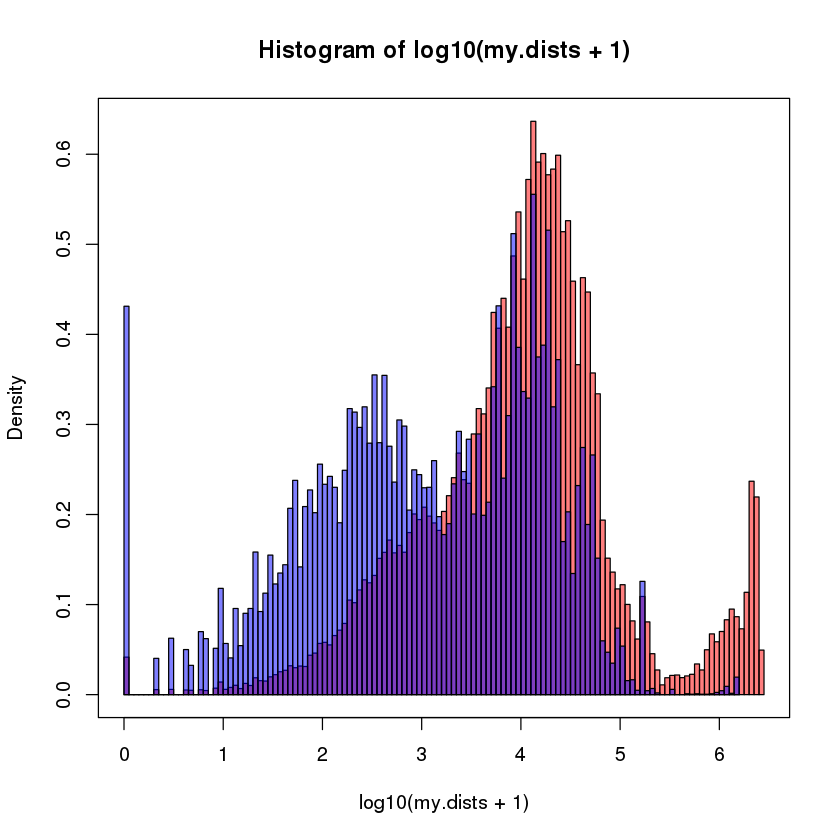

In [182]:
# Histogram Colored (blue and red)
hist(log10(my.dists+1), breaks = 100, freq = FALSE, col=rgb(1,0,0,0.5))
hist(log10(my.dists.c+1), breaks = 100, freq = FALSE, col=rgb(0,0,1,0.5), add=TRUE)
box()

In [213]:
x.t <- log10(my.dists.c+1)
y.t <- gc.content.chip
x.f <- log10(my.dists+1)
y.f <- gc.content

N <- min(length(x.t),length(x.f))
inds.t <- sample(length(x.t), N, replace=FALSE)
inds.f <- sample(length(x.f), N, replace=FALSE)

x.t.s <- x.t[inds.t]
y.t.s <- y.t[inds.t]
x.f.s <- x.f[inds.f]
y.f.s <- y.f[inds.f]

t.df <- data.frame(Log.TSS.Dist=x.t.s, GC.Content=y.t.s, Class="True Positive")
f.df <- data.frame(Log.TSS.Dist=x.f.s, GC.Content=y.f.s, Class="False Positive")
newfeat.df <- rbind(t.df, f.df)

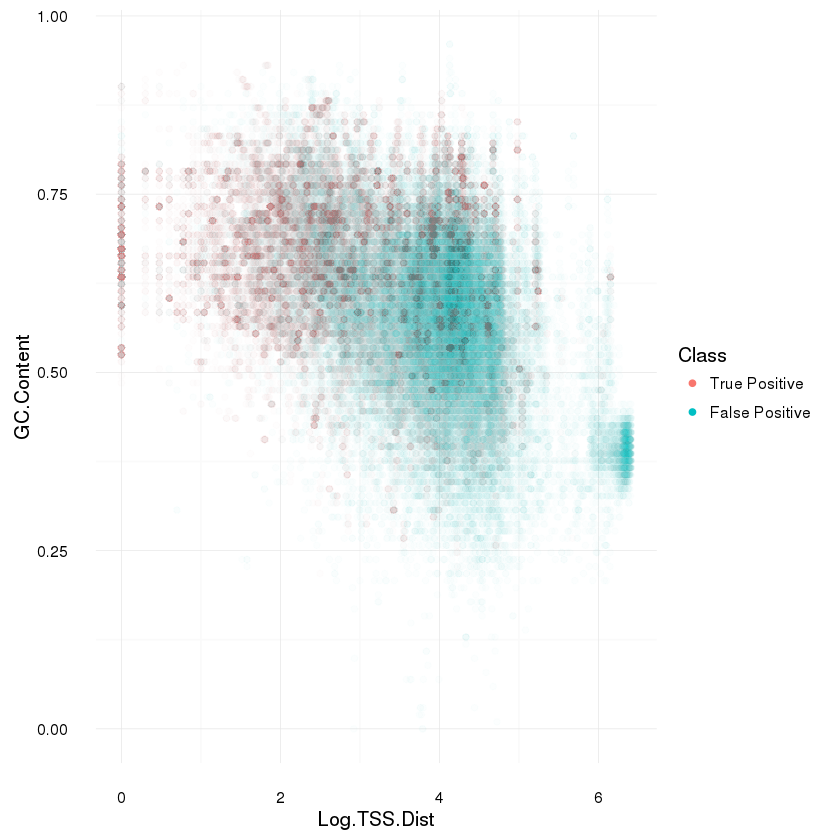

In [218]:
ggplot(newfeat.df, aes(x=Log.TSS.Dist, y=GC.Content, color=Class)) + 
geom_point(alpha=0.01) + 
guides(colour = guide_legend(override.aes = list(alpha = 1))) +
theme_minimal()

## Deep Learning Results

In [70]:
valid.DL <- read.csv("neuron1_valid.csv", header = FALSE)

In [76]:
str(valid.DL[,1])

 num [1:1126] 0.964 0.363 0.363 0.414 0.363 ...


In [74]:
str()

 num [1:1126] 0 0 1 0 0 0 0 0 1 1 ...


In [77]:
DL.roc <- roc(as.numeric(y.valid),valid.DL[,1])


Call:
roc.default(response = as.numeric(y.valid), predictor = valid.DL[,     1])

Data: valid.DL[, 1] in 563 controls (as.numeric(y.valid) 0) > 563 cases (as.numeric(y.valid) 1).
Area under the curve: 0.6474

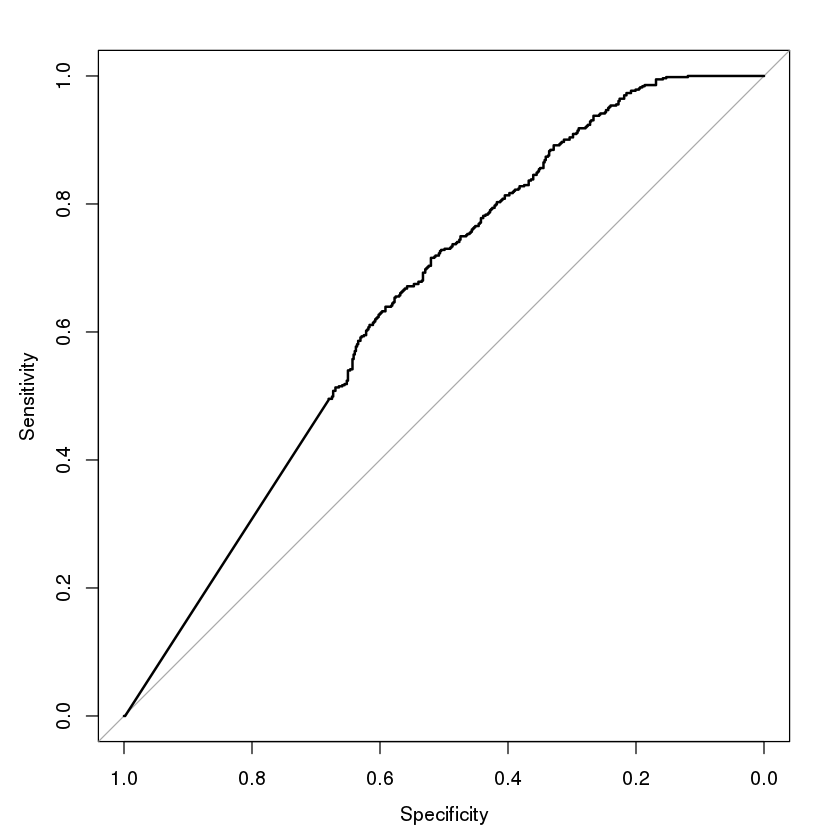

In [78]:
plot(DL.roc)

In [83]:
mean(as.numeric(y.valid) == 1-round(valid.DL[,1]))

[1] 0.6092362